In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 90.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 110.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 23.7 MB/s eta 0:00:00


In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split

# Dataset class
class StanceDataset(Dataset):
    def __init__(self, targets, statements, labels, tokenizer, max_length):
        self.targets = targets
        self.statements = statements
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        target = self.targets[idx]
        statement = self.statements[idx]
        combined_text = f"{target} [SEP] {statement}"
        encoding = self.tokenizer.encode_plus(
            combined_text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt",
            return_attention_mask=True,
            return_token_type_ids=False,
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }



In [ ]:
# Pandas function to clean Twitter text by removing URLs, mentions, and hashtags
import re

def clean_text(text):
    text = re.sub(r"http\S+", " ", text)
    text = re.sub(r"@\S+", " ", text)

    # Remove hashtag but keep the text
    text = re.sub(r"#", " ", text)

    # Remove non ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)

    # Remove extra whitespace and multiple whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Convert Stance FOR 0, AGAINST 1, NONE 2
def convert_stance(stance):
    if stance == -1:
        return 0

    if stance == 'FAVOR':
        return 1

    if stance == 'AGAINST':
      return 0

    if stance == 'PRO':
      return 1

    else:
        return 1
    
# Prepare the dataset
def prepare_dataset(df, tokenizer, max_length):
    targets = df['text_a'].values
    statements = df['cleaned_text'].values
    labels = df['labels'].values
    dataset = StanceDataset(targets, statements, labels, tokenizer, max_length)
    return dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Task 1

In [ ]:
import pandas as pd

# Read tab-separated .txt file and convert to pandas dataframe
# UTF encoding is used to handle emojis
def read_data(filename):
    columns = ['claim_label', 'text_a', 'text_b', 'id', 'labels']
    df = pd.read_csv(filename, sep='\t', encoding='utf-8', names = columns)
    return df

# Read the data
iam_1 = read_data('/content/drive/MyDrive/Datasets/train.txt')
iam_2 = read_data('/content/drive/MyDrive/Datasets/test.txt') 

iam_df = pd.concat([iam_1,iam_2], axis=0, ignore_index=True)

# Stance Data

col_names = ['id', 'text_a', 'text_b', 'labels']
cols_to_load = ['ID', 'Target', 'Tweet', 'Stance']

# cols_to_load = 
stance_1 = pd.read_csv('/content/drive/MyDrive/Datasets/trainingdata-all-annotations.txt', sep='\t', encoding = 'utf-8', usecols = cols_to_load)
stance_2 = pd.read_csv('/content/drive/MyDrive/Datasets/testdata-taskA-all-annotations.txt', sep='\t', encoding = 'utf-8', usecols = cols_to_load)

stance_1.columns = ['id', 'text_a', 'text_b', 'labels']
stance_2.columns = ['id', 'text_a', 'text_b', 'labels']

stance_df = pd.concat([stance_1,stance_2], axis=0, ignore_index=True)
final_df = pd.concat([iam_df, stance_df], axis=0, ignore_index=True)
# Final FTC data 

cols = ['document_id', 'posted_date', 'month_year', 'state_province', 'country', 'comment', 'FINAL']

final_df.head()

,claim_label,text_a,text_b,id,labels
0,C,Should we ban the production of generic drugs,One long-standing solution to mitigating costs...,61_12,-1
1,C,Should we ban the production of generic drugs,So there’s an almost universally accepted desi...,61_12,-1
2,C,Should we ban the production of generic drugs,Even if this gets some people cheaper drugs in...,61_12,1
3,C,Should we ban the production of generic drugs,"For example, generics have been admonished for...",61_12,1
4,C,Should we ban the production of generic drugs,"Speaking of Shkreli, generics are just as capa...",61_12,1


In [ ]:
# Combine IAM and Stance Dataset

train_df, val_df = train_test_split(final_df, test_size=0.2, random_state=25)
train_df.head()

,claim_label,text_a,text_b,id,labels
7670,NaN,Climate Change is a Real Concern,"What has been will be again, what has been don...",10319,NONE
48,C,Should we eliminate traditional newspapers,With newspapers entering bankruptcy even as th...,9_10,1
6781,NaN,Legalization of Abortion,@peiacsw please consider the status of preborn...,2484,AGAINST
6691,NaN,Legalization of Abortion,Still waiting for Libs to explain how the prem...,2394,AGAINST
2552,C,Should we fight for the Olympics?,Although hosting the games comes with a certai...,3_9,1


In [ ]:
# Only filter Opinion towards == "TARGET" for both train and val
# train_df = train_df[train_df['Opinion towards'] == 'TARGET']
# val_df = val_df[val_df['Opinion towards'] == 'TARGET']

# # Remove Stance being NONE
train_df = train_df[train_df['labels'] != 'NONE']
val_df = val_df[val_df['labels'] != 'NONE']

# Get number of rows for train and val
train_size = train_df.shape[0]
val_size = val_df.shape[0]


print(f"Train size: {train_size}")
print(f"Val size: {val_size}")

Train size: 6022
Val size: 1506


In [ ]:
# Clean the text
train_df['cleaned_text'] = train_df['text_b'].apply(clean_text)
val_df['cleaned_text'] = val_df['text_b'].apply(clean_text)

train_df.tail()

,claim_label,text_a,text_b,id,labels,cleaned_text
1175,C,Should you stay away from online dating,A form of misrepresentation is that members ma...,106_2,1,A form of misrepresentation is that members ma...
8447,NaN,Legalization of Abortion,@Fungirl3part2 repent wen u commit a grave act...,11096,AGAINST,repent wen u commit a grave act like murder of...
2934,C,Should we legalize same-sex marriage?,"Marriage is about more than procreation, there...",20_10,1,"Marriage is about more than procreation, there..."
6618,NaN,Legalization of Abortion,#SB724 passes Sen. Judiciary Cmte.This bill is...,2321,FAVOR,SB724 passes Sen. Judiciary Cmte.This bill is ...
8510,NaN,Legalization of Abortion,Looking forward to the protest today. I can't ...,11159,AGAINST,Looking forward to the protest today. I can't ...


In [ ]:
val_df.head()

,claim_label,text_a,text_b,id,labels,cleaned_text
2155,C,Does online shopping promote economic development,The online shopping has definitely become uniq...,109_6,1,The online shopping has definitely become uniq...
3914,C,Should we legalize same-sex marriage?,According to The 2007 Pew Global Attitudes Pro...,20_7,1,According to The 2007 Pew Global Attitudes Pro...
4269,C,Should we cancel the standardized test for uni...,Standardized tests put large amounts of pressu...,62_4,1,Standardized tests put large amounts of pressu...
3845,C,Should sex education courses be compulsory in ...,The research has shown it time and time again:...,46_9,1,The research has shown it time and time again:...
1374,C,Shouldn't bullfighting be banned,There is a great deal of controversy around bu...,54_9,1,There is a great deal of controversy around bu...


In [ ]:
# Value counts for each stance
train_df['labels'].value_counts()

1          1886
AGAINST    1684
-1         1627
FAVOR       825
Name: labels, dtype: int64

In [ ]:
# Value counts for each stance
val_df['labels'].value_counts()

1          468
-1         417
AGAINST    388
FAVOR      233
Name: labels, dtype: int64

In [ ]:
# Remove rows with empty text on cleaned_tweet
train_df = train_df[train_df['cleaned_text'] != '']
val_df = val_df[val_df['cleaned_text'] != '']

In [ ]:
# Convert the labels to integers
train_df['labels'] = train_df['labels'].apply(convert_stance)
val_df['labels'] = val_df['labels'].apply(convert_stance)

In [ ]:
train_df.head()

,claim_label,text_a,text_b,id,labels,cleaned_text
48,C,Should we eliminate traditional newspapers,With newspapers entering bankruptcy even as th...,9_10,1,With newspapers entering bankruptcy even as th...
6781,NaN,Legalization of Abortion,@peiacsw please consider the status of preborn...,2484,0,please consider the status of preborn girls as...
6691,NaN,Legalization of Abortion,Still waiting for Libs to explain how the prem...,2394,0,Still waiting for Libs to explain how the prem...
2552,C,Should we fight for the Olympics?,Although hosting the games comes with a certai...,3_9,1,Although hosting the games comes with a certai...
7718,NaN,Climate Change is a Real Concern,@JustinTrudeau Hey Justin I will give you 50 c...,10367,0,Hey Justin I will give you 50 cents if you sto...


In [ ]:
# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
max_length = 128
train_dataset = prepare_dataset(train_df, tokenizer, max_length)
val_dataset = prepare_dataset(val_df, tokenizer, max_length)

In [ ]:
# Create DataLoader
batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

In [ ]:
# Initialize BERT model for sequence classification
num_labels = len(set(train_df['labels'].unique()))  # number of unique stance labels 
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)
model.dropout = torch.nn.Dropout(0.5)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
# Set up training parameters
epochs = 4
learning_rate = 2e-5

# Use torch AdamW optimizer
# Import AdamW from torch
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

In [ ]:
# Create training loop with validation per epoch
from tqdm import tqdm
from sklearn.metrics import accuracy_score

# Store training and validation loss, and accuracy for plotting
train_loss_values = []
val_loss_values = []
val_accuracy_values = []

for epoch in tqdm(range(epochs)):
    # Training loop
    model.train()
    train_loss = 0

    for batch in train_dataloader:
        inputs = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(inputs, attention_mask=attention_mask, labels=labels)
        
        loss = outputs.loss
        train_loss += loss.item()
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    # Get average training loss
    avg_train_loss = train_loss / len(train_dataloader)

    # Validation loop
    model.eval()
    val_loss = 0

    # Store predictions and true labels
    preds_validation = []
    labels_validation = []

    for batch in val_dataloader:
        inputs = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        with torch.no_grad():
            outputs = model(inputs, attention_mask=attention_mask, labels=labels)
            # Get output predictions logits
            logits = outputs.logits

            # Get predictions
            preds = torch.argmax(logits, dim=1).flatten()

            # Get loss
            loss = outputs.loss
            val_loss += loss.item()

            # Get predictions and labels
            # preds look like torch.Tensor([1, 0, 1, 1, ...])
            # labels look like torch.Tensor([1, 0, 1, 1, ...])

            # Tensor -> cpu -> numpy -> list
            preds_validation.extend(preds.cpu().numpy().tolist())
            labels_validation.extend(labels.cpu().numpy().tolist())

    # Get average validation loss
    avg_val_loss = val_loss / len(val_dataloader)

    # Calculate accuracy, f1, precision, and recall
    accuracy = accuracy_score(labels_validation, preds_validation)

    # Print training and validation loss
    print(f"[{epoch+1}]: Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.2f}")

    # Save training and validation loss for plotting
    train_loss_values.append(avg_train_loss)
    val_loss_values.append(avg_val_loss)
    val_accuracy_values.append(accuracy)

 25%|██▌       | 1/4 [02:16<06:48, 136.15s/it]

[1]: Training Loss: 0.6176, Validation Loss: 0.5321, Accuracy: 0.75


 50%|█████     | 2/4 [04:38<04:39, 139.84s/it]

[2]: Training Loss: 0.4328, Validation Loss: 0.4599, Accuracy: 0.79


 75%|███████▌  | 3/4 [07:05<02:23, 143.13s/it]

[3]: Training Loss: 0.2802, Validation Loss: 0.5318, Accuracy: 0.80


100%|██████████| 4/4 [09:33<00:00, 143.30s/it]

[4]: Training Loss: 0.1748, Validation Loss: 0.6170, Accuracy: 0.80


Text(0.5, 1.0, 'Training and Validation loss')

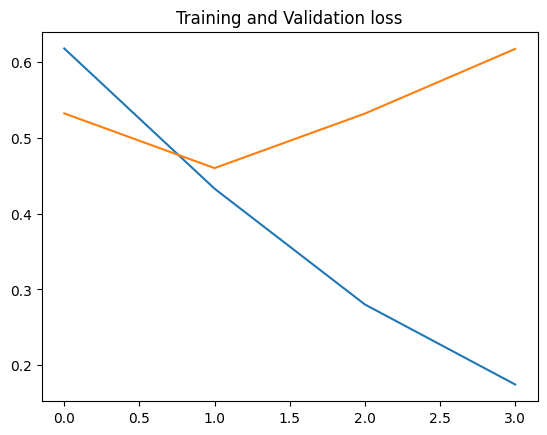

In [ ]:
# Plot training and validation loss
import matplotlib.pyplot as plt

plt.plot(train_loss_values, label='Training loss')
plt.plot(val_loss_values, label='Validation loss')
plt.title('Training and Validation loss')

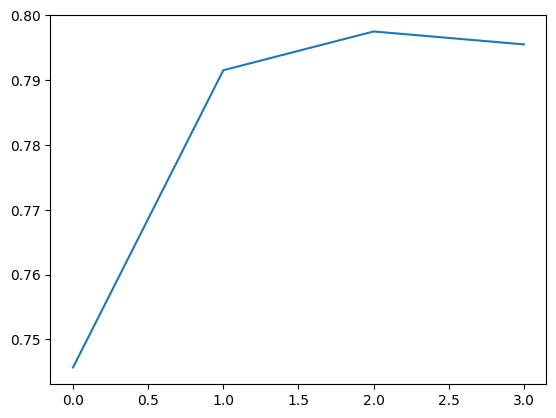

In [ ]:
# Plot validation accuracy
plt.plot(val_accuracy_values, label='Validation accuracy')

In [ ]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = 'bert-semeval'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model to bert-semeval


('bert-semeval/tokenizer_config.json',
 'bert-semeval/special_tokens_map.json',
 'bert-semeval/vocab.txt',
 'bert-semeval/added_tokens.json')

# Running Model on FTC Dataset 

In [ ]:
# ftc_df = pd.read_csv('/content/drive/MyDrive/Datasets/ftc_comments_cln_v3.csv', sep=',', encoding='utf-8', usecols = cols)
ftc_df = pd.read_csv('/content/drive/MyDrive/Datasets/ftc_comments_cln_v4.csv', sep=',', encoding='utf-8', usecols = cols)

# Drop NaN values
ftc_df = ftc_df.dropna(subset=['comment'])

# # Remove Stance being NONE
ftc_df = ftc_df[ftc_df['FINAL'] != 'NEUTRAL']

# Filter NaN FINAL values
ftc_df = ftc_df.dropna(subset=['FINAL'])

ftc_size = ftc_df.shape[0]
print(f"FTC size: {ftc_size}")

# Clean the text
ftc_df['cleaned_comment'] = ftc_df['comment'].apply(clean_text)

print(ftc_df['FINAL'].value_counts())

FTC size: 1070
PRO        930
AGAINST    140
Name: FINAL, dtype: int64


In [ ]:
ftc_df['FINAL'] = ftc_df['FINAL'].apply(convert_stance)

In [ ]:
ftc_df.head()

,document_id,posted_date,month_year,state_province,country,comment,FINAL,cleaned_comment
1,FTC-2023-0007-10001,2023-03-20T04:00Z,2023-03,NaN,NaN,I as a physician and I strongly support the ba...,1,I as a physician and I strongly support the ba...
2,FTC-2023-0007-10002,2023-03-20T04:00Z,2023-03,TX,United States,I as a physician strongly support the ban on n...,1,I as a physician strongly support the ban on n...
3,FTC-2023-0007-10003,2023-03-20T04:00Z,2023-03,MI,United States,Elimination of non-compete contracts for physi...,0,Elimination of non-compete contracts for physi...
4,FTC-2023-0007-10004,2023-03-20T04:00Z,2023-03,TX,United States,Non compete clause is not good for patient car...,1,Non compete clause is not good for patient car...
5,FTC-2023-0007-10005,2023-03-20T04:00Z,2023-03,WI,United States,Comment:I as a physician strongly support the ...,1,Comment:I as a physician strongly support the ...


In [ ]:
ftc_df['target'] = 'Should bans on non-compete be implemented?'

In [ ]:
# Get value counts of stance labels
ftc_df['FINAL'].value_counts()

1    930
0    140
Name: FINAL, dtype: int64

In [ ]:
ftc_df.head()

,document_id,posted_date,month_year,state_province,country,comment,FINAL,cleaned_comment,target
1,FTC-2023-0007-10001,2023-03-20T04:00Z,2023-03,NaN,NaN,I as a physician and I strongly support the ba...,1,I as a physician and I strongly support the ba...,Should bans on non-compete be implemented?
2,FTC-2023-0007-10002,2023-03-20T04:00Z,2023-03,TX,United States,I as a physician strongly support the ban on n...,1,I as a physician strongly support the ban on n...,Should bans on non-compete be implemented?
3,FTC-2023-0007-10003,2023-03-20T04:00Z,2023-03,MI,United States,Elimination of non-compete contracts for physi...,0,Elimination of non-compete contracts for physi...,Should bans on non-compete be implemented?
4,FTC-2023-0007-10004,2023-03-20T04:00Z,2023-03,TX,United States,Non compete clause is not good for patient car...,1,Non compete clause is not good for patient car...,Should bans on non-compete be implemented?
5,FTC-2023-0007-10005,2023-03-20T04:00Z,2023-03,WI,United States,Comment:I as a physician strongly support the ...,1,Comment:I as a physician strongly support the ...,Should bans on non-compete be implemented?


In [ ]:
# Prepare the dataset
def prepare_dataset(df, tokenizer, max_length):
    targets = df['target'].values
    statements = df['cleaned_comment'].values
    labels = df['FINAL'].values
    dataset = StanceDataset(targets, statements, labels, tokenizer, max_length)
    return dataset

In [ ]:
# Divide FTC dataset into training and validation
training_data, testing_data = train_test_split(ftc_df, test_size=0.2, random_state=25)

max_length = 128
train_dataset = prepare_dataset(training_data, tokenizer, max_length)
val_dataset = prepare_dataset(testing_data, tokenizer, max_length)

# Create DataLoader
batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)


In [ ]:
# Load finetuned model from task1
tokenizer = BertTokenizer.from_pretrained('bert-semeval')
model = BertForSequenceClassification.from_pretrained('bert-semeval', ignore_mismatched_sizes = True, num_labels = 2)

In [ ]:
# Initialize BERT model for sequence classification
num_labels = len(set(training_data['FINAL'].unique()))  # number of unique stance labels 

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
# Set up training parameters
epochs = 4
learning_rate = 2e-5

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

In [ ]:
# Create training loop with validation per epoch
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef

# Store training and validation loss, and accuracy for plotting
train_loss_values = []
val_loss_values = []
val_accuracy_values = []

for epoch in tqdm(range(epochs)):
    # Training loop
    model.train()
    train_loss = 0

    for batch in train_dataloader:
        inputs = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(inputs, attention_mask=attention_mask, labels=labels)
        
        loss = outputs.loss
        train_loss += loss.item()
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    # Get average training loss
    avg_train_loss = train_loss / len(train_dataloader)

    # Validation loop
    model.eval()
    val_loss = 0

    # Store predictions and true labels
    preds_validation = []
    labels_validation = []

    for batch in val_dataloader:
        inputs = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        with torch.no_grad():
            outputs = model(inputs, attention_mask=attention_mask, labels=labels)
            # Get output predictions logits
            logits = outputs.logits

            # Get predictions
            preds = torch.argmax(logits, dim=1).flatten()

            # Get loss
            loss = outputs.loss
            val_loss += loss.item()

            # Get predictions and labels
            # preds look like torch.Tensor([1, 0, 1, 1, ...])
            # labels look like torch.Tensor([1, 0, 1, 1, ...])

            # Tensor -> cpu -> numpy -> list
            preds_validation.extend(preds.cpu().numpy().tolist())
            labels_validation.extend(labels.cpu().numpy().tolist())

    # Get average validation loss
    avg_val_loss = val_loss / len(val_dataloader)

    # Calculate accuracy, f1, precision, and recall
    accuracy = accuracy_score(labels_validation, preds_validation)

    # Matthews Coeff due to highly imbalanced dataset

    matthew_coeff = matthews_corrcoef(labels_validation, preds_validation)

    # Print training and validation loss
    print(f"[{epoch+1}]: Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.2f}, Matthews Correlation Coefficient: {matthew_coeff:.2f}")

    # Save training and validation loss for plotting
    train_loss_values.append(avg_train_loss)
    val_loss_values.append(avg_val_loss)
    val_accuracy_values.append(accuracy)

 25%|██▌       | 1/4 [00:20<01:02, 20.87s/it]

[1]: Training Loss: 0.3715, Validation Loss: 0.1859, Accuracy: 0.93, Matthews Correlation Coefficient: 0.51


 50%|█████     | 2/4 [00:42<00:42, 21.07s/it]

[2]: Training Loss: 0.1191, Validation Loss: 0.0624, Accuracy: 0.99, Matthews Correlation Coefficient: 0.92


 75%|███████▌  | 3/4 [01:08<00:23, 23.44s/it]

[3]: Training Loss: 0.0375, Validation Loss: 0.0775, Accuracy: 0.98, Matthews Correlation Coefficient: 0.89


100%|██████████| 4/4 [01:31<00:00, 22.76s/it]

[4]: Training Loss: 0.0153, Validation Loss: 0.0718, Accuracy: 0.98, Matthews Correlation Coefficient: 0.89


Text(0.5, 1.0, 'Training and Validation loss')

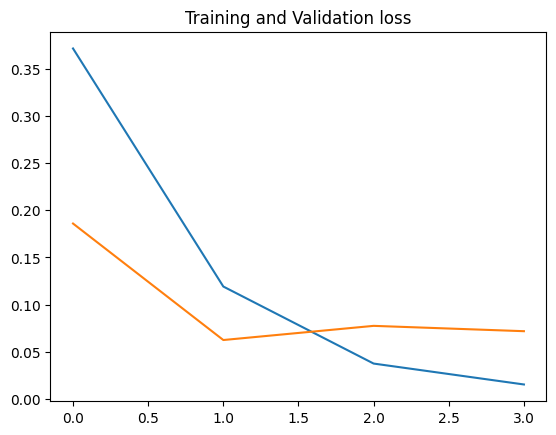

In [ ]:
# Plot training and validation loss
import matplotlib.pyplot as plt

plt.plot(train_loss_values, label='Training loss')
plt.plot(val_loss_values, label='Validation loss')
plt.title('Training and Validation loss')

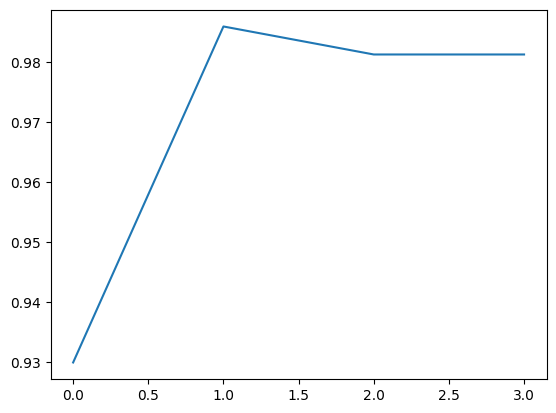

In [ ]:
# Plot validation accuracy
plt.plot(val_accuracy_values, label='Validation accuracy')

In [ ]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()
output_dir = 'bert-ftc'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model to bert-ftc


('bert-ftc/tokenizer_config.json',
 'bert-ftc/special_tokens_map.json',
 'bert-ftc/vocab.txt',
 'bert-ftc/added_tokens.json')

# Predict Tagging for Dataset
Need to run utils functions at the beginning

In [ ]:
# Dataset class
class StanceDatasetPredict(Dataset):
    # Doesnt have LABELS
    def __init__(self, targets, statements, tokenizer, max_length):
        self.targets = targets
        self.statements = statements
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        target = self.targets[idx]
        statement = self.statements[idx]
        combined_text = f"{target} [SEP] {statement}"
        encoding = self.tokenizer.encode_plus(
            combined_text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt",
            return_attention_mask=True,
            return_token_type_ids=False,
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Datasets/ftc_comments_cln_untagged.csv')

df = df[df['comment'].notna()]
df['cleaned_comment'] = df['comment'].apply(clean_text)
df['target'] = 'Should bans on non-compete be implemented?'

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-ftc')
model = BertForSequenceClassification.from_pretrained('bert-ftc', ignore_mismatched_sizes = True, num_labels = 2)

In [ ]:
def prepare_dataset(df, tokenizer, max_length):
    targets = df['target'].values
    statements = df['cleaned_comment'].values
    dataset = StanceDatasetPredict(targets, statements, tokenizer, max_length)
    return dataset

max_length = 128
test_dataset = prepare_dataset(df, tokenizer, max_length)

# Create DataLoader
batch_size = 16
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
# Set model to evaluation mode
model.to('cuda')
for param in model.parameters():
    param.requires_grad = False
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
device = 'cuda'
preds_validation = []

for param in model.parameters():
    param.requires_grad = False

model.eval()

for batch in test_dataloader:
    inputs = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(inputs, attention_mask=attention_mask, labels=None)
        # Get output predictions logits
        logits = outputs.logits

        # Get predictions
        preds = torch.argmax(logits, dim=1).flatten()


        # Get predictions and labels
        # preds look like torch.Tensor([1, 0, 1, 1, ...])
        # labels look like torch.Tensor([1, 0, 1, 1, ...])

        # Tensor -> cpu -> numpy -> list
        preds_validation.extend(preds.cpu().numpy().tolist())

In [ ]:
# has the predictions
# preds_validation

import numpy as np

df['pred_tag'] = np.array(preds_validation)
df.to_csv('/content/drive/MyDrive/Datasets/final_tag.csv', index=False)

In [ ]:
df.head()

,document_id,posted_date,month_year,state_province,country,comment,cleaned_comment,target
0,FTC-2023-0007-2637,2023-01-18T05:00Z,2023-01,UT,United States,I am very much in support of this ban and the ...,I am very much in support of this ban and the ...,Should bans on non-compete be implemented?
1,FTC-2023-0007-2638,2023-01-18T05:00Z,2023-01,NY,United States,This rule is sorely needed. Non-compete clause...,This rule is sorely needed. Non-compete clause...,Should bans on non-compete be implemented?
2,FTC-2023-0007-2639,2023-01-18T05:00Z,2023-01,NaN,NaN,I fully support this proposed rule. This also ...,I fully support this proposed rule. This also ...,Should bans on non-compete be implemented?
3,FTC-2023-0007-2640,2023-01-18T05:00Z,2023-01,NaN,United States,The definition of “noncompete clause” does not...,The definition of noncompete clause does not a...,Should bans on non-compete be implemented?
4,FTC-2023-0007-2641,2023-01-18T05:00Z,2023-01,NaN,NaN,Noncompete agreements stifle competition and a...,Noncompete agreements stifle competition and a...,Should bans on non-compete be implemented?
